In [4]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as mpl

%matplotlib inline
mpl.style.use('ggplot')
mpl.rcParams['figure.figsize'] = 16,6


# 2.1a

On a series of E-Mini S&P 500 futures tick data:

Form tick, volume, and dollar bars. Use the ETF trick to deal with the roll.

In [5]:
from load_data import load_contracts

es_cons = load_contracts('@ES')

In [6]:
dictio = DICTIO = {'Instrument':'Instrument', 'Close':'Close', 'Open':'Open', }

def getRolledSeries(series, dictio=DICTIO):
    gaps = rollGaps(series, dictio)
    for field in ['Close', 'Volume']:
        series[field] -= gaps
    return series


def rollGaps(series, dictio, matchEnd=True):
    # Compute gaps at each roll, between previous close and next open
    rollDates = series[dictio['Instrument']].drop_duplicates(keep='first').index
    gaps = series[dictio['Close']] * 0
    iloc = list(series.index)
    iloc = [iloc.index(i) - 1 for i in rollDates] # index of days prior to roll
    gaps.loc[rollDates[1:]] = series[dictio['Open']].loc[rollDates[1:]] - series[dictio['Close']].iloc[iloc[1:]].values
    gaps = gaps.cumsum()
    if matchEnd:
        gaps -= gaps.iloc[-1]
    return gaps

rolled_es = getRolledSeries(es_cons)

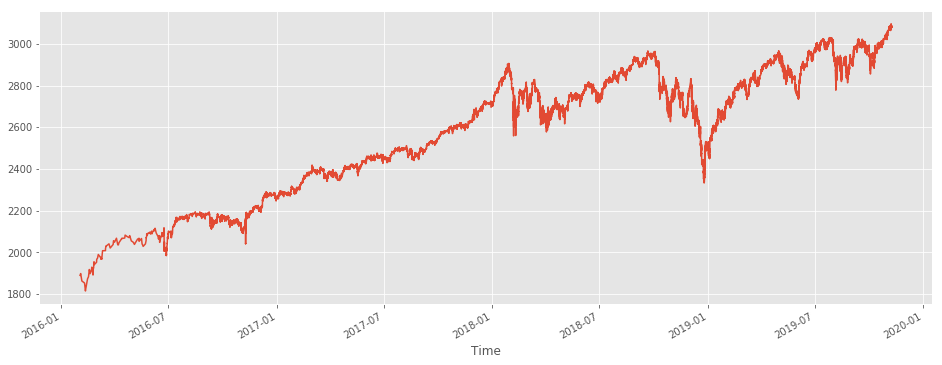

In [8]:
rolled_es['Close'].plot();

In [13]:
from sampling import non_negative_series, volume_bars, dollar_bars

bars = non_negative_series(rolled_es['2019-01-01':])

vbars = volume_bars(bars)
dbars = dollar_bars(bars)

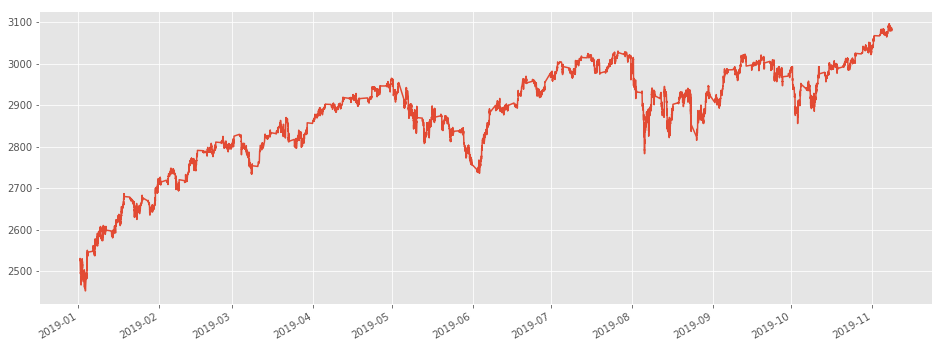

In [14]:
vbars['Close'].plot();

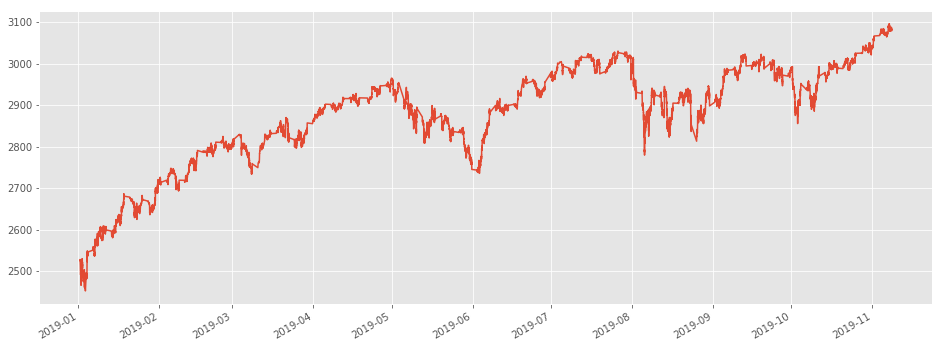

In [15]:
dbars['Close'].plot();

# 2.1b

On a series of E-Mini S&P 500 futures tick data:

Count the number of bars produced by tick, volume, and dollar bars on a weekly basis.
Plot a time series of that bar count. What bar type produces the most stable weekly count? Why?


In [17]:
volume_weeklies = vbars.set_index(vbars['Time']).resample('1W').count()['Close']
dollar_weeklies = dbars.set_index(dbars['Time']).resample('1W').count()['Close']

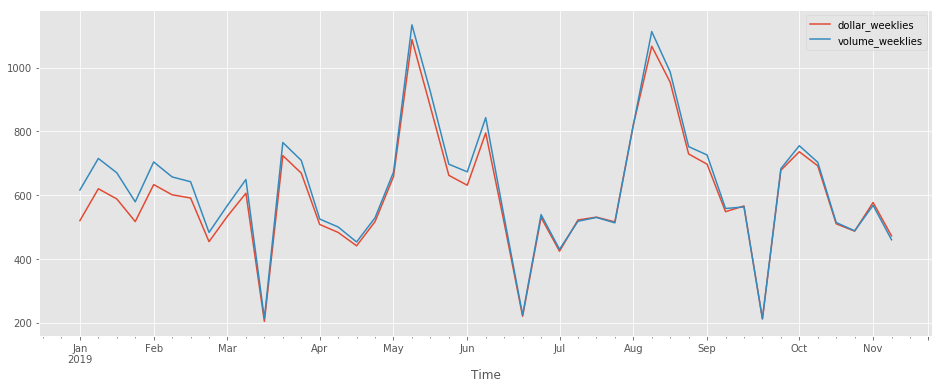

In [18]:
together = pd.DataFrame({'volume_weeklies': volume_weeklies, 'dollar_weeklies': dollar_weeklies})
together.plot();

In [20]:
print("Dollar bars' sampling speed does not fluctuate with price and thus appears the more stable method.")

Dollar bars' sampling speed does not fluctuate with price and thus appears the more stable method.


# 2.1c

On a series of E-Mini S&P 500 futures tick data:

Compute the serial correlations of returns of the three bar types.
What bar method has the lowest serial correlation?


In [24]:
print("Minute bars serial correlation: {:.6f}".format(bars['rPrices'].autocorr()))
print("Volume bars serial correlation: {:.6f}".format(vbars['rPrices'].autocorr()))
print("Dollar bars serial correlation: {:.6f}".format(dbars['rPrices'].autocorr()))
print("\nDollar bars seem to have the lowest serial correlation")

Minute bars serial correlation: 0.999985
Volume bars serial correlation: 0.999867
Dollar bars serial correlation: 0.999852

Dollar bars seem to have the lowest serial correlation



# 2.1d

On a series of E-Mini S&P 500 futures tick data:

Partition the bar series into monthly subsets. Compute the variance of returns for every
subset of every bar type. Compute the variance of those variances. What method exhibits the
smallest variance of variances?


In [36]:
# Minute bars left out since they're sampled at a much higher frequency and distort results
print('Volume bars', vbars['rPrices'].resample('1M').var().var())
print('Dollar bars', dbars['rPrices'].resample('1M').var().var())

print('\nDollar bars appear to have the lower variance of variances.')

Volume bars 5.0715595904222927e-08
Dollar bars 4.919137017006292e-08

Dollar bars appear to have the lower variance of variances.


# 2.1e

On a series of E-Mini S&P 500 futures tick data:

Apply the Jarque-Bera normality test on returns from the three bar types. What method
achieves the lowest test statistic?


In [37]:
from scipy import stats

print('Minute bars', stats.jarque_bera(bars['Close'].pct_change()[1:])[0])
print('Volume bars', stats.jarque_bera(vbars['Close'].pct_change()[1:])[0])
print('Dollar bars', stats.jarque_bera(dbars['Close'].pct_change()[1:])[0])

print('Volume bars achieve the lowest test statistic')

Minute bars 132495318.13287506
Volume bars 221246.1391989312
Dollar bars 339956.5558177701
Volume bars achieve the lowest test statistic


# 2.2

On a series of E-Mini S&P 500 futures tick data compute dollar bars and dollar imbalance bars. What bar type exhibits
greater serial correlation?



# 2.3a

On a dollar bar series of E-mini S&P 500 futures and Eurostoxx 50 futures:

Apply Section 2.4.2 to compute the allocations vector used by the ETF trick.
(Hint: you will need FX values for EUR/USD at the roll dates).

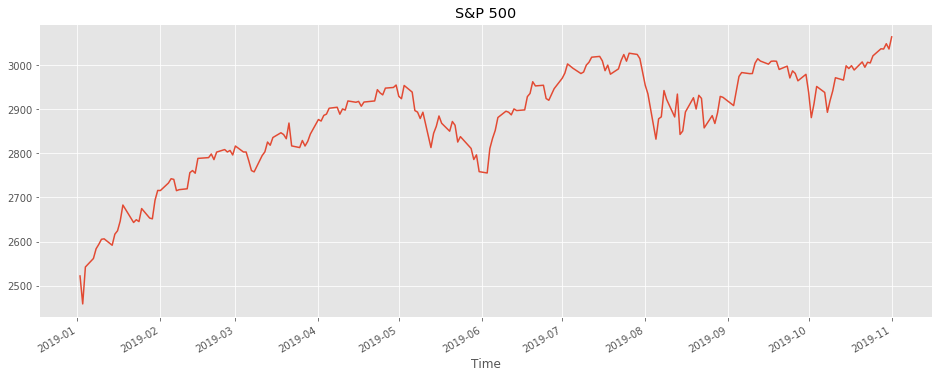

In [58]:
es_contracts = load_contracts('ES', 'daily')
rolled_es = getRolledSeries(es_contracts)
es_bars = non_negative_series(rolled_es['2019-01-01':])

stx_contracts = load_contracts('EX', 'daily')
rolled_stx = getRolledSeries(stx_contracts)
stx_bars = non_negative_series(rolled_stx['2019-01-01':])

es_bars['Close'].plot(title='S&P 500');

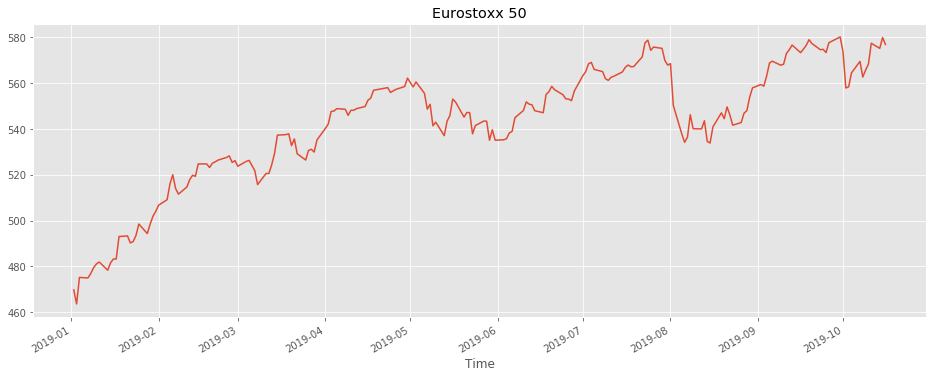

In [57]:
stx_bars['Close'].plot(title='Eurostoxx 50');

In [46]:
def pca_weights(cov, riskDist=None, riskTarget=1.0):
    # Following the riskAlloc, distribution, match riskTarget
    eVal, eVec = np.linalg.eigh(cov) # must be Hermitian
    indices = eVal.argsort()[::-1] # arguments for sorting eVal desc
    eVal, eVec = eVal[indices], eVec [:, indices]
    if riskDist is None:
        riskDist = np.zeros(cov.shape[0])
        riskDist[-1] = 1.0
    loads = riskTarget * (riskDist / eVal) ** 0.5
    weights = np.dot(eVec, np.reshape(loads, (-1, 1)))

    return weights

np.random.seed(42)

stx_dollar_bars = dollar_bars(stx_bars)
es_dollar_bars = dollar_bars(es_bars)

prices = pd.concat({'EUR_STX': stx_dollar_bars['Close'], 'ES': es_dollar_bars['Close']}, axis=1)
prices = prices.ffill().bfill()

# Generate random FX data for EURUSD
eur_usd = np.random.normal(1, 0.0001, len(prices)).cumprod()
prices['EURUSD'] = eur_usd
prices['STX'] = prices['EUR_STX'] / prices['EURUSD']


cov = prices[['STX', 'ES']].pct_change()[1:].cov()
weights = pca_weights(cov)

# 2.3b

On a dollar bar series of E-mini S&P 500 futures and Eurostoxx 50 futures:

Derive the time series of the S&P 500/Eurostoxx 50 spread.


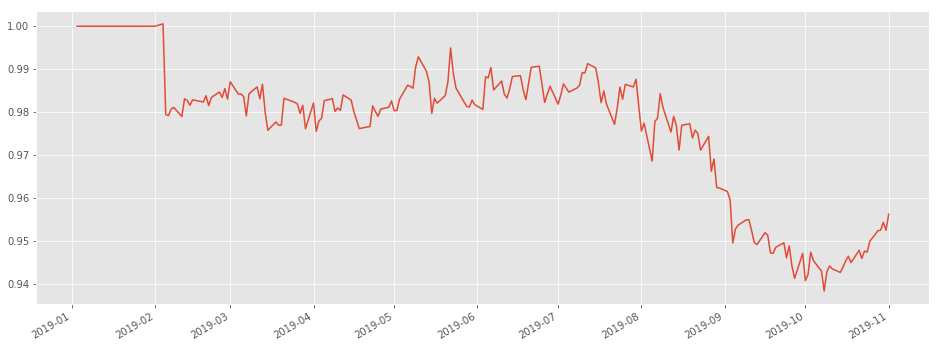

In [49]:
prices = prices[['STX', 'ES']]
cov = prices.pct_change().rolling(22).cov()
fd = cov.index.levels[0]
weights = pd.Series(fd).apply(lambda x: pca_weights(cov.loc[x]))

split_w = weights.apply(lambda xx:[x[0] for x in xx]).apply(pd.Series)
xx = pd.concat([split_w])
xx.columns = cov.columns
xx = xx.add_suffix('_w')
xx = xx.div(xx.abs().sum(axis=1), axis=0).abs().fillna(0)

prices['STX_w'] = xx['STX_w'].values
prices['ES_w'] = xx['ES_w'].values
prices['spread_returns'] = prices['ES'].pct_change() * prices['ES_w'] - prices['STX'].pct_change() * prices['STX_w']
prices['spread'] = (1 + prices['spread_returns']).cumprod()
prices['spread'].plot();

# 2.3c

On a dollar bar series of E-mini S&P 500 futures and Eurostoxx 50 futures:

Confirm that the series is stationary, with an ADF test.


In [65]:
es_cons = load_contracts('ES')
stx_cons = load_contracts('EX')
rolled_es = getRolledSeries(es_cons)
tricked_es = non_negative_series(rolled_es['2019-01-01':])
rolled_stx = getRolledSeries(stx_cons)
tricked_stx = non_negative_series(rolled_stx['2019-01-01':])

es_dollar_bars = dollar_bars(tricked_es)
stx_dollar_bars = dollar_bars(tricked_stx)

In [66]:
from statsmodels.tsa import stattools as stt
es_adf = stt.adfuller(es_dollar_bars['Close'])
stx_adf = stt.adfuller(stx_dollar_bars['Close'])

print("S&P 500 dollar bars:")
print("Test statistic: {:.3f}".format(es_adf[0]))
print("Critical value 95%: {:.3f}".format(es_adf[4]['5%']))
print("The S&P 500 dollar bars do not appear stationary at the 95% level.")
print()
print("Eurostoxx 50 dollar bars:")
print("Test statistic: {:.3f}".format(stx_adf[0]))
print("Critical value 95%: {:.3f}".format(stx_adf[4]['5%']))
print("The Eurostoxx 50 dollar bars do appear stationary at the 95% level.")

S&P 500 dollar bars:
Test statistic: -2.323
Critical value 95%: -2.862
The S&P 500 dollar bars do not appear stationary at the 95% level.

Eurostoxx 50 dollar bars:
Test statistic: -1.981
Critical value 95%: -2.862
The Eurostoxx 50 dollar bars do appear stationary at the 95% level.


# 2.4a

Form E-mini S&P 500 futures dollar bars:

Compute Bollinger Bands of width 5% around a rolling moving average.

Count how many times prices cross the bands out (from within the bands to outside the bands).


Crosses up & out: 153
Crosses down & out: 98


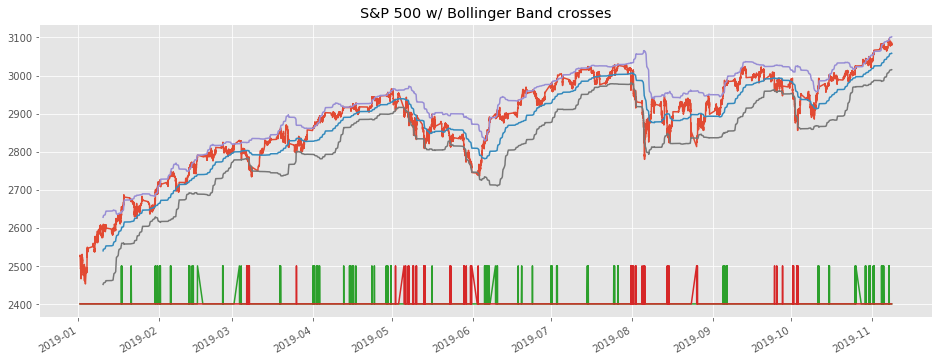

In [78]:
close = es_dollar_bars['Close']

MA = close.rolling(1000).mean()
STD = close.rolling(1000).std()
upper_band = MA + 2 * STD
lower_band = MA - 2 * STD

close.plot()
MA.plot()
upper_band.plot()
lower_band.plot()

crosses_up = ((close > upper_band) & ~(close.shift(1) > upper_band.shift(1)))
crosses_down = ((close < lower_band) & ~(close.shift(1) < lower_band.shift(1)))
print("Crosses up & out:", crosses_up.sum())
print("Crosses down & out:", crosses_down.sum())
(crosses_up.astype(float) * 100 + 2400).plot(color='tab:green')
(crosses_down.astype(float) * 100 + 2400).plot(color='tab:red', title='S&P 500 w/ Bollinger Band crosses');

**Green bars indicate the price crossing up out of the Bollinger Bands, red crossing down out of the Bollinger Bands.**

# 2.4b

Form E-mini S&P 500 futures dollar bars:

Now sample those bars using a CUMSUM filter, where {yt} are returns and h = 0.05. How many samples do you get?

In [80]:
from filters import cusum

sampled_index = cusum(es_dollar_bars['Close'], 0.05)
sampled = es_dollar_bars[es_dollar_bars.index.isin(sampled_index)]

print("The CUSUM filter sampled {} out of {} bars".format(len(sampled), len(es_dollar_bars)))

The CUSUM filter sampled 12453 out of 26922 bars


# 2.4c

Form E-mini S&P 500 futures dollar bars:

c) Compute the rolling standard deviation of the two-sampled series. Which one is least heteroskedastic? What is the
reason for these results?


In [84]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white
from statsmodels.formula.api import ols

rstd_es = es_dollar_bars['Close'].rolling(10).std()
rstd_es_sampled = sampled['Close'].rolling(10).std()

def test_heteroskedasticity(series):
    df = pd.DataFrame(series)
    df['index'] = range(len(df.index))
    model = ols(formula='Close~index', data=df).fit()
    white_test = het_white(model.resid,  model.model.exog)
    labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']

    return dict(zip(labels, white_test))

print("White test on rolling(10) S&P 500 standard deviation:")
print(test_heteroskedasticity(rstd_es))
print()
print("White test on CUSUM sampled rolling(10) S&P 500 standard deviation:")
print(test_heteroskedasticity(rstd_es_sampled))
print()
print("The non-sampled bars appear less heteroskedastic.")

White test on rolling(10) S&P 500 standard deviation:
{'F-Test p-value': 2.838994127260086e-06, 'LM Statistic': 25.534847924708266, 'F-Statistic': 12.778124560412142, 'LM-Test p-value': 2.852188503631e-06}

White test on CUSUM sampled rolling(10) S&P 500 standard deviation:
{'F-Test p-value': 7.978643617707399e-05, 'LM Statistic': 18.86255456966736, 'F-Statistic': 9.44331772714249, 'LM-Test p-value': 8.01767259900096e-05}

The non-sampled bars appear less heteroskedastic.


# 2.5a

Using the bars from exercise 4

Sample bars using the CUSUM filter, where $\{y_t\}$ are absolute returns and $h$ = 0.05.


# 2.5b

Using the bars from exercise 4

Compute the rolling standard deviation of the sampled bars.


# 2.5c

Using the bars from exercise 4

Compare this result with the results from exercise 4. What procedure delivered the least heteroscedastic
sample? Why?
